In [7]:
import keras
from keras.layers import Activation, Dense, Dropout, Conv2D, \
                         Flatten, MaxPooling2D, LSTM, TimeDistributed, Reshape, Lambda, Conv1D, MaxPooling1D, BatchNormalization
from keras.models import Sequential
from keras.callbacks import TensorBoard
import librosa
import librosa.display
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from tensorflow.keras.models import Model
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

In [14]:
# Read Data
data = pd.read_csv('UrbanSounds8K/metadata/UrbanSound8K.csv')
data.head(5)

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [15]:
data.shape

(8732, 8)

In [16]:
# Get data over 3 seconds long
valid_data = data[['slice_file_name', 'fold' ,'classID', 'class']][ data['end']-data['start'] >= 3 ]
valid_data.shape

(7468, 4)

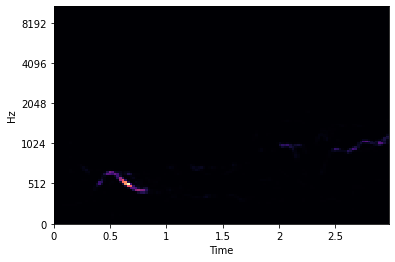

In [17]:
y, sr = librosa.load('UrbanSounds8K/audio/fold9/13579-2-0-16.wav', duration=2.97)
ps = librosa.feature.melspectrogram(y=y, sr=sr)
ps.shape

mel_sgram = librosa.amplitude_to_db(ps, ref=np.min)

librosa.display.specshow(ps, y_axis='mel', x_axis='time')

In [18]:
valid_data['path'] = 'fold' + valid_data['fold'].astype('str') + '/' + valid_data['slice_file_name'].astype('str')

In [6]:
#Use it to create data ######################################################################
def creates_train_data():
    D = [] # Dataset

    for row in valid_data.itertuples():
        y, sr = librosa.load('UrbanSounds8K/augmented/ps2_m25/' + row.path, duration=2.97)  #2.97 = 3*1000 - 3*1000/128  ###############################
        ps = librosa.feature.melspectrogram(y=y, sr=sr)
        if ps.shape != (128, 128): continue
        D.append( (ps, row.classID) )
    np.save('train_data_augmented_ps2_m25.npy', D) ###############################
    return D

In [9]:
np.load.__defaults__=(None, True, True, 'ASCII')
a = np.load('train_data.npy')
b = np.load('train_data_augmented_speed_81.npy')
c = np.load('train_data_augmented_speed_107.npy')
d = np.load('train_data_augmented_ps1_2.npy')
e = np.load('train_data_augmented_ps2_m25.npy')

# np.savez('train.npz',a,b,c,d,e) ############################################################################
# r = np.load('train.npz') ############################################################################
# locals().update(r) ############################################################################

tuple = (a,b,c,d,e)
tuplearr = np.vstack(tuple)
len(tuplearr)
dataset = tuplearr
random.shuffle(dataset)
len(dataset)

37303

In [10]:
#To see how many samples are in X-train and y-train
kf = KFold(n_splits=10)

count = 0

keras.backend.clear_session()

def ReshapeLayer(x):
    
    shape = x.shape
    
    # 1 possibility: H,W*channel
    reshape = Reshape((shape[1],shape[2]*shape[3]))(x)
    
    # 2 possibility: W,H*channel
    # transpose = Permute((2,1,3))(x)
    # reshape = Reshape((shape[1],shape[2]*shape[3]))(transpose)
    
    return reshape

for train_set, test_set in kf.split(dataset):
     print( train_set, test_set)
     print("-----------breaking line--------------")
     #X_train, X_test, y_train, y_test = dataset[train_set], dataset[test_set]
 
     print('----------------------------')
     count += 1
     print(count)
     print('----------------------------')
 
     X_train,y_train = zip(*dataset[train_set])
     X_test, y_test = zip(*dataset[test_set])
 
     # Reshape for CNN input
     X_train = np.array([x.reshape( (128, 128) ) for x in X_train])
     X_test = np.array([x.reshape( (128, 128) ) for x in X_test])
 
     # One-Hot encoding for classes
     y_train = np.array(keras.utils.to_categorical(y_train, 10))
     y_test = np.array(keras.utils.to_categorical(y_test, 10))

 
     NAME = "graphic-{}-".format(int(time.time()))
     tensorboard = TensorBoard(log_dir='E4-epoch_48-{}'.format(NAME +  str(count)))
 
 
     model = Sequential()

     model.add(
        Conv1D(24, kernel_size=(5), input_shape=(128, 128), kernel_regularizer=keras.regularizers.l2(0.001))
        )
     model.add(MaxPooling1D(8))
     model.add(Activation('relu'))
     model.add(Dropout(rate=0.25))
 
     model.add(Conv1D(48, kernel_size=(1), padding="valid", kernel_regularizer=keras.regularizers.l2(0.001)))
     model.add(MaxPooling1D(8))
     model.add(Activation('relu'))
     model.add(Dropout(rate=0.25))
 
     model.add(Conv1D(48, kernel_size=(1), padding="valid", kernel_regularizer=keras.regularizers.l2(0.001)))
     model.add(Activation('relu'))

     model.add(
        LSTM(units = 32, dropout = 0.5, return_sequences=True)
        ) 
   
     model.add(LSTM(32, dropout = 0.5))

     model.add(BatchNormalization())

     model.add(Dense(10))
     model.add(Activation('softmax'))
 
     model.compile(
 	    optimizer="Adam",
 	    loss="categorical_crossentropy",
 	    metrics=['accuracy']
        )


     model.fit(
 	    x=X_train, 
 	    y=y_train,
        epochs=48,
        batch_size=128,
        validation_data = (X_test, y_test),
        shuffle= False,
 	      callbacks=[tensorboard]
 	    )
 
     score = model.evaluate(
 	    x=X_test,
 	    y=y_test
        )
 
     print('Test loss:', score[0])
     print('Test accuracy:', score[1])
    


model.save('SoundClassification-E4.model')


[ 3731  3732  3733 ... 37300 37301 37302] [   0    1    2 ... 3728 3729 3730]
-----------breaking line--------------
----------------------------
1
----------------------------
Epoch 1/48
  1/263 [..............................] - ETA: 0s - loss: 2.7834 - accuracy: 0.1094WARNING:tensorflow:From C:\Users\Guest1\anaconda3\envs\backup_20220216_20220322\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
263/263 [==============================] - 6s 22ms/step - loss: 2.3997 - accuracy: 0.1524 - val_loss: 2.2433 - val_accuracy: 0.2219
Epoch 2/48
263/263 [==============================] - 4s 17ms/step - loss: 2.1796 - accuracy: 0.2042 - val_loss: 1.9930 - val_accuracy: 0.3031
Epoch 3/48
263/263 [==============================] - 4s 17ms/step - loss: 2.0467 - accuracy: 0.2411 - val_loss: 1.8798 - val_accuracy: 0.33

In [ ]:
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

raise StopExecution

StopExecution: 

In [2]:
model = tf.keras.models.load_model("SoundClassification-E4.model")

In [6]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_27 (Conv1D)           (None, 124, 24)           15384     
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 15, 24)            0         
_________________________________________________________________
activation_36 (Activation)   (None, 15, 24)            0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 15, 24)            0         
_________________________________________________________________
conv1d_28 (Conv1D)           (None, 15, 48)            1200      
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, 1, 48)             0         
_________________________________________________________________
activation_37 (Activation)   (None, 1, 48)            

In [4]:
def prepare(filepath):
    y, sr = librosa.load(filepath, duration=2.97)
    ps = librosa.feature.melspectrogram(y=y, sr=sr)
    ps.shape
    if ps.shape != (128,128):
        new_image_width = 128
        new_image_height = 128
        color = (0)
        result = np.full((new_image_height,new_image_width, 1), color, dtype=np.uint8)
        return result.reshape(1, 128, 128)

    else:
        return ps.reshape(-1, 128, 128)

In [5]:
from os import walk

mypath = 'Test/'
f = []
for (dirpath, dirnames, filenames) in walk(mypath):
    f.extend(filenames)
    break
print(len(f))
print(f)

10
['AC_0.wav', 'CarHorn_1.wav', 'ChildrenPlaying_2.wav', 'DogBark_3.wav', 'Drill_4.wav', 'EngineIdling_5_2.wav', 'GunShot_6.wav', 'Jackhammer_7.wav', 'Siren_8.wav', 'StreetMusic_9.wav']


In [ ]:
count = 0

for file in f:
    count += 1
    prediction = model.predict([prepare('Test/'+file)])
    y_classes = prediction.argmax(axis=-1)
    max = np.amax(prediction)
    print(str(count) + " th")
    print(file)
    print("Match accuracy: " + str(max))
    print("class: " + str(y_classes))
    print(prediction)
    print("-----------------------")